In [ ]:
import numpy as np
from sklearn.utils import shuffle
import pandas as pd

In [ ]:
class NeuralNetwork(object):

    def __init__(self, numNeuronList, thetas, alpha, regLambda, sortedClassValues=np.array([0, 1]), isNumeric=False,
                 numOutputs=1, filePath='None', logs=False):
        self.numNeuronList = numNeuronList
        self.thetas = thetas
        self.alpha = alpha
        self.regLambda = regLambda
        self.sortedClassValues = sortedClassValues
        self.isNumeric = isNumeric
        self.numOutputs = numOutputs
        self.filePath = filePath
        self.logs = logs

    def sigmoid(self, z):
        a= (1 / (1 + np.exp(-z)))
        # print(a)
        np.warnings.filterwarnings('ignore', 'overflow')
        return 1 / (1 + np.exp(-z))

    def costFunction(self, data_frame):

        numLayers = self.numNeuronList.size
        j = 0
        n = data_frame.shape[0]
        iter = 1
        for dataRow in data_frame:
            activation = np.insert(dataRow[:-self.numOutputs], 0, 1)
            layerLog = 1
            if self.logs:
                print('a{layer} : {activationArray}'.format(layer=layerLog, activationArray=activation))
            for layer in range(1, numLayers - 1):
                layerLog += 1
                z = np.dot(self.thetas[layer - 1], activation)
                if self.logs:
                    print('z{layer} : {zArray}'.format(layer=layerLog, zArray=z))
                activation = self.sigmoid(z)
                activation = np.insert(activation, 0, 1)
                if self.logs:
                    print('a{layer} : {activationArray}'.format(layer=layerLog, activationArray=activation))
            z = np.dot(self.thetas[numLayers - 2], activation)
            layerLog += 1
            if self.logs:
                print('z{layer} : {zArray}'.format(layer=layerLog, zArray=z))

            output = self.sigmoid(z)

            if self.logs:
                print('a{layer} : {activationArray}'.format(layer=layerLog, activationArray=output))

            if not self.isNumeric:
                y = np.zeros(self.sortedClassValues.size)
                y[self.sortedClassValues.tolist().index(dataRow[-1])] = 1
            else:
                y = dataRow[-self.numOutputs:]

            if self.logs:
                print('f(x): {outputs}'.format(outputs=output))

            temp = -y * np.log(output) - (1 - y) * np.log(1 - output)

            if self.logs:
                print('Predicted output for instance {iter}: {outputs}'.format(iter=iter, outputs=output))
                print('Expected output for instance {iter}: {yLog}'.format(iter=iter, yLog=y))
                print('Cost, J, associated with instance {iter}: {cost}'.format(iter=iter, cost=sum(temp)))
                print('-----------------------------------------------------')
            j += sum(temp)
            iter += 1

        j /= n
        s = 0
        for key in self.thetas:
            temp = self.thetas[key][:, 1:]
            s += np.sum(temp * temp)

        s = (self.regLambda / (2 * n)) * s

        j += s

        if self.logs:
            print('Final (regularized) cost, j, based on the complete training set: {j}'.format(j=j))

        return j

    def costFunctionTestSet(self, data_frame):

        numLayers = self.numNeuronList.size
        j = 0
        n = data_frame.shape[0]
        iter = 1
        for dataRow in data_frame:
            activation = np.insert(dataRow[:-self.numOutputs], 0, 1)
            layerLog = 1

            for layer in range(1, numLayers - 1):
                layerLog += 1
                z = np.dot(self.thetas[layer - 1], activation)
                activation = self.sigmoid(z)
                activation = np.insert(activation, 0, 1)

            z = np.dot(self.thetas[numLayers - 2], activation)
            layerLog += 1

            output = self.sigmoid(z)

            if not self.isNumeric:
                y = np.zeros(self.sortedClassValues.size)
                y[self.sortedClassValues.tolist().index(dataRow[-1])] = 1
            else:
                y = dataRow[-self.numOutputs:]

            temp = -y * np.log(output) - (1 - y) * np.log(1 - output)

            j += sum(temp)
            iter += 1

        j /= n

        return j

    def trainBatch(self, data_frame):
        activation = {}
        delta = {}
        gradients = {}
        numLayers = self.numNeuronList.size
        for i in self.thetas:
            gradients[i] = np.zeros(self.thetas[i].shape)
        iter = 0
        if self.logs:
            print('-------------------------------------------------------')
            print('Running back propogation')
        for dataRow in data_frame:
            iter += 1
            activation[0] = np.insert(dataRow[:-self.numOutputs], 0, 1)

            for layer in range(1, numLayers - 1):
                z = np.dot(self.thetas[layer - 1], activation[layer - 1])
                activation[layer] = self.sigmoid(z)
                activation[layer] = np.insert(activation[layer], 0, 1)
            z = np.dot(self.thetas[numLayers - 2], activation[numLayers - 2])

            activation[numLayers - 1] = self.sigmoid(z)
            output = activation[numLayers - 1]

            if not self.isNumeric:
                y = np.zeros(self.sortedClassValues.size)
                y[self.sortedClassValues.tolist().index(dataRow[-1])] = 1
            else:
                y = dataRow[-self.numOutputs:]

            if self.logs:
                print('Computing gradients based on training instance {iter}:\n'.format(iter=iter))

            delta[numLayers - 1] = output - y

            if self.logs:
                print('delta{layer}: {delta}'.format(layer=numLayers, delta=delta[numLayers - 1]))

            for layer in range(1, numLayers - 1):
                delta[numLayers - 1 - layer] = np.dot(np.transpose(self.thetas[numLayers - 1 - layer]),
                                                      delta[numLayers - layer]) * activation[numLayers - 1 - layer] * (
                                                       1 - activation[numLayers - 1 - layer])
                delta[numLayers - 1 - layer] = delta[numLayers - 1 - layer][1:]
                if self.logs:
                    print('delta{layer}: {delta}'.format(layer=numLayers - layer, delta=delta[numLayers - 1 - layer]))

            if self.logs:
                print('\n')

            for layer in range(1, numLayers):
                temp = np.dot(
                    delta[numLayers - layer].reshape(delta[numLayers - layer].shape[0], 1),
                    activation[numLayers - 1 - layer].reshape(1, activation[numLayers - 1 - layer].shape[0]))
                gradients[numLayers - 1 - layer] = gradients[numLayers - 1 - layer] + temp
                if self.logs:
                    print('Gradients of Theta{layerNum} based on training instance {iter}: \n{gradient}\n'.format(layerNum=numLayers-layer, iter=iter, gradient=temp))

        if self.logs:
            print('\nThe entire training set has been processed. Computing the average (regularized) gradients:\n')

        for layer in range(1, numLayers):
            p = self.regLambda * self.thetas[numLayers - 1 - layer]
            p[:, 0] = 0
            gradients[numLayers - 1 - layer] = (gradients[numLayers - 1 - layer] + p) / data_frame.shape[0]
            if self.logs:
                print('Final regularized gradients of Theta{layerLog}: \n{gradient}\n'.format(layerLog=numLayers-layer, gradient=gradients[numLayers - 1 - layer]))

        for layer in range(1, numLayers):
            self.thetas[numLayers - 1 - layer] = self.thetas[numLayers - 1 - layer] - self.alpha * gradients[
                numLayers - 1 - layer]

    def train(self, data_frame, batchSizePercentage=10):
        j = 0
        n = data_frame.shape[0]
        numElemInEachBatch = int(n / batchSizePercentage)

        stoppingCondition = 0.001
        if self.filePath == 'datasets/hw3_wine.csv':
            stoppingCondition = 0.0001

        for iter in range(500):
            if self.filePath == 'datasets/hw3_wine.csv':
                self.trainBatch(data_frame)
            else:
                if numElemInEachBatch >= 1:
                    for i in range(int(batchSizePercentage)):
                        if i == int(batchSizePercentage) - 1:
                            self.trainBatch(data_frame[i * numElemInEachBatch:, :])
                        else:
                            self.trainBatch(data_frame[i * numElemInEachBatch: (i + 1) * numElemInEachBatch, :])
                else:
                    # This code is to run the special test cases in the assignment
                    self.trainBatch(data_frame)
                    break

            cost = self.costFunction(data_frame)
            #print('CostFunction ', iter, ': ', cost)
            if abs(cost - j) < stoppingCondition:
                j = cost
                break
            j = cost
        return j

    def predict(self, test_set):

        outputs = np.array([])
        numLayers = self.numNeuronList.size

        for dataRow in test_set:
            activation = np.insert(dataRow[:-self.numOutputs], 0, 1)
            for layer in range(1, numLayers - 1):
                z = np.dot(self.thetas[layer - 1], activation)
                activation = self.sigmoid(z)
                activation = np.insert(activation, 0, 1)
            z = np.dot(self.thetas[numLayers - 2], activation)

            output = self.sigmoid(z)

            if not self.isNumeric:
                outputs = np.append(outputs, self.sortedClassValues[output.tolist().index(max(output))])
            else:
                if outputs.size == 0:
                    outputs = np.array([output])
                else:
                    outputs = np.append(outputs, [output], axis=0)

        #if not self.logs:
            #print('output: ', outputs)

        return outputs

In [ ]:
def evaluationMetrics(filePath, numNeuronList, alpha, regLambda, numFolds=10, trainingSetPercentage=100, costOfTestSet=False):
    print('entered')
    if filePath == 'hw3_cancer.csv':
        data_frame = pd.read_csv(filePath, sep='\t')
        data = data_frame.to_numpy()

    elif filePath == 'hw3_house_votes_84.csv':
        data_frame = pd.read_csv(filePath)
        data_without_encoding = data_frame.to_numpy()
        # One Hot Encoding
        data = np.array([])
        for dataRow in data_without_encoding:
            oneHotEncoding = np.array([])
            for feature in dataRow[:-1]:
                if feature == 0:
                    oneHotEncoding = np.append(oneHotEncoding, np.array([0, 0, 1]))
                if feature == 1:
                    oneHotEncoding = np.append(oneHotEncoding, np.array([0, 1, 0]))
                if feature == 2:
                    oneHotEncoding = np.append(oneHotEncoding, np.array([1, 0, 0]))
            oneHotEncoding = np.append(oneHotEncoding, dataRow[-1])
            if data.size == 0:
                data = oneHotEncoding
            else:
                data = np.vstack([data, oneHotEncoding])

    elif filePath == 'hw3_wine.csv':
        data_frame = pd.read_csv(filePath, sep='\t')
        data = data_frame.to_numpy()
        labels = data[:, 0]
        data = data[:, 1:]
        data = np.concatenate((data, np.transpose(np.array([labels]))), axis=1)

    elif filePath == 'cmc.csv':
        data_frame = pd.read_csv(filePath, sep=',', header=None)
        data_without_encoding = data_frame.to_numpy()
        data_without_encoding = data_without_encoding.astype(float)

        min = np.min(data_without_encoding[:, 0])
        max = np.max(data_without_encoding[:, 0])

        data_without_encoding[:, 0] = (data_without_encoding[:, 0] - min) / (max - min)

        min = np.min(data_without_encoding[:, 3])
        max = np.max(data_without_encoding[:, 3])

        data_without_encoding[:, 3] = (data_without_encoding[:, 3] - min) / (max - min)

        data = np.array([])
        for dataRow in data_without_encoding:
            oneHotEncoding = np.array([])
            featureNumber = 0
            for feature in dataRow[:-1]:
                if featureNumber == 1 or featureNumber == 2 or featureNumber == 6 or featureNumber == 7:
                    if feature == 1:
                        oneHotEncoding = np.append(oneHotEncoding, np.array([0, 0, 0, 1]))
                    if feature == 2:
                        oneHotEncoding = np.append(oneHotEncoding, np.array([0, 0, 1, 0]))
                    if feature == 3:
                        oneHotEncoding = np.append(oneHotEncoding, np.array([0, 1, 0, 0]))
                    if feature == 4:
                        oneHotEncoding = np.append(oneHotEncoding, np.array([1, 0, 0, 0]))

                elif featureNumber == 4 or featureNumber == 5 or featureNumber == 8:
                    if feature == 0:
                        oneHotEncoding = np.append(oneHotEncoding, np.array([0, 1]))
                    if feature == 1:
                        oneHotEncoding = np.append(oneHotEncoding, np.array([1, 0]))
                else:
                    oneHotEncoding = np.append(oneHotEncoding, feature)
                featureNumber += 1

            oneHotEncoding = np.append(oneHotEncoding, dataRow[-1])
            if data.size == 0:
                data = oneHotEncoding
            else:
                data = np.vstack([data, oneHotEncoding])

    else:
        return

    sortedClassValues = np.sort(np.unique(data[:, -1]))

    trainDataForFolds = {}
    testDataForFolds = {}
    splitDataBasedOnLabels = {}
    countOfEachClassInDataSet = {}
    for classValue in sortedClassValues:
        countOfEachClassInDataSet[classValue] = 0
        splitDataBasedOnLabels[classValue] = np.array([x for x in data if x[-1] == classValue])

    for data_row in data:
        countOfEachClassInDataSet[data_row[-1]] += 1

    for iter in np.arange(numFolds):
        for classValue in sortedClassValues:
            foldCount = round(countOfEachClassInDataSet.get(classValue) / numFolds)
            if testDataForFolds.get(iter) is None:
                testDataForFolds[iter] = splitDataBasedOnLabels.get(classValue)[foldCount * iter:foldCount * (iter + 1),
                                         :]
                trainDataForFolds[iter] = np.array(
                    [x for index, x in enumerate(splitDataBasedOnLabels.get(classValue)) if
                     (index < foldCount * iter or index >= foldCount * (iter + 1))])
            else:
                testDataForFolds[iter] = np.append(testDataForFolds.get(iter), splitDataBasedOnLabels.get(classValue)[
                                                                               foldCount * iter:foldCount * (iter + 1),
                                                                               :], axis=0)
                trainDataForFolds[iter] = np.append(trainDataForFolds.get(iter), np.array(
                    [x for index, x in enumerate(splitDataBasedOnLabels.get(classValue)) if
                     (index < foldCount * iter or index >= foldCount * (iter + 1))]), axis=0)

    evaluationMetricsForAllFolds = np.array([])

    thetas = {}
    costFunctionsForEachFold = np.array([])
    costFunctionsForEachTestFold = np.array([])
    #print('-----------------------------------------------------------------------------\n')

    #print('Dataset : ', filePath)
    #print('Neural Network architecture: ')
    #print('Number of neurons in each layer:', numNeuronList)
    #print('Alpha: ', alpha)
    #print('Lambda: ', regLambda)
    #print('Percentage of training data used to train the neural network: ', trainingSetPercentage, '\n\n')

    for iter in np.arange(numFolds):

        for layer in range(1, numNeuronList.size):
            thetas[layer - 1] = np.random.normal(0, 1, size=(numNeuronList[layer], numNeuronList[layer - 1] + 1))
        accuracy = 0.0
        precision = 0.0
        recall = 0.0

        predictionsCount = {}
        originalTestClassesCount = {}
        for classValue in sortedClassValues:
            predictionsCount[classValue] = np.array([0, 0])
            originalTestClassesCount[classValue] = 0

        train_data_frame = shuffle(trainDataForFolds.get(iter))
        train_data_frame = train_data_frame[0: int(0.01 * trainingSetPercentage * train_data_frame.shape[0]), :]
        test_data_frame = shuffle(testDataForFolds.get(iter))

        test_labels = test_data_frame[:, -1]

        for test_label in test_labels:
            originalTestClassesCount[test_label] += 1

        #print('Training and Predicting: Fold Number: ', iter + 1)

        if filePath == 'datasets/hw3_cancer.csv' or filePath == 'datasets/hw3_wine.csv':
            minimum = train_data_frame[:, :-1].min(axis=0)
            maximum = train_data_frame[:, :-1].max(axis=0)

            train_data_frame[:, :-1] -= minimum
            train_data_frame[:, :-1] /= (maximum - minimum)

            minimum = test_data_frame[:, :-1].min(axis=0)
            maximum = test_data_frame[:, :-1].max(axis=0)

            test_data_frame[:, :-1] -= minimum
            test_data_frame[:, :-1] /= (maximum - minimum)

        if filePath == 'datasets/hw3_wine.csv':
            classifier = NeuralNetwork(numNeuronList, thetas, alpha, regLambda, sortedClassValues, filePath=filePath)
        else:
            classifier = NeuralNetwork(numNeuronList, thetas, alpha, regLambda, sortedClassValues)
        j = classifier.train(train_data_frame)
        costFunctionsForEachFold = np.append(costFunctionsForEachFold,j)
        if costOfTestSet:
            costFunctionsForEachTestFold = np.append(costFunctionsForEachTestFold, classifier.costFunctionTestSet(test_data_frame))
        predictions = classifier.predict(test_data_frame)
        for j in np.arange(test_data_frame.shape[0]):
            if test_labels[j] == predictions[j]:
                predictionsCount.get(predictions[j])[0] += 1
                accuracy += 1
            else:
                predictionsCount.get(predictions[j])[1] += 1

        accuracy = accuracy / test_data_frame.shape[0]

        for classValue in sortedClassValues:
            if np.sum(predictionsCount.get(classValue)) != 0:
                precision += predictionsCount.get(classValue)[0] / np.sum(predictionsCount.get(classValue))
            recall += predictionsCount.get(classValue)[0] / originalTestClassesCount.get(classValue)

        precision /= sortedClassValues.size
        recall /= sortedClassValues.size
        f1Score = (2 * precision * recall) / (precision + recall)

        if iter == 0:
            evaluationMetricsForAllFolds = np.array([np.array([accuracy, precision, recall, f1Score])])
        else:
            evaluationMetricsForAllFolds = np.concatenate((evaluationMetricsForAllFolds,
                                                           np.array(
                                                               [np.array([accuracy, precision, recall, f1Score])])),
                                                          axis=0)

    #print(evaluationMetricsForAllFolds)
    #print(costFunctionsForEachFold)
    return evaluationMetricsForAllFolds, costFunctionsForEachFold, costFunctionsForEachTestFold

In [ ]:
def run(filePath, architectures, alpha=1):
    # s=pd.read_csv(filePath)
    # print(s.head())
    lambdas = [0.25, 0.5, 0.75]
    iter = 1
    for architecture in architectures:
        print('\nArchitecture {iter}: {layers}:'.format(iter=iter, layers=architecture))
        for lambdaValue in lambdas:
            print('\nlambda = {lambdaValue}:'.format(lambdaValue=lambdaValue))
            evaluationMetricsForAllFolds, costFunctionsForEachFold, costFunctionsForEachTestFold = evaluationMetrics(filePath,np.array(architecture), alpha,lambdaValue)
            print('Evaluation metrics [Accuracy, Precision, Recall, F1 Score]: ',
                  np.average(evaluationMetricsForAllFolds, axis=0))
            print('Cost Function: ', np.average(costFunctionsForEachFold))
        iter += 1


# Press the green button in the gutter to run the script.


In [ ]:
if __name__ == '__main__':
    # print('-------------------------------House Votes Dataset-----------------------------------------')
    # architectures = [[48, 24, 16, 2], [48, 24, 24, 2], [48, 24, 16, 8, 2],
    #                  [48, 24, 16, 16, 2], [48, 24, 16, 8, 4, 2], [48, 24, 16, 16, 8, 2]]
    # run('hw3_house_votes_84.csv', architectures)
    print('\n-----------------------------------Wine Dataset-------------------------------------')
    architectures = [[13, 10, 3]]
    # architectures = [[13, 4, 3], [13, 8, 3], [13, 8, 4, 3], [13, 8, 8, 3], [13, 8, 6, 4, 3], [13, 8, 8, 8, 3]]
    run('hw3_wine.csv', architectures)
    # print('\n--------------------------------Breast Cancer Dataset----------------------------------------')
    # architectures = [[9, 4, 2], [9, 8, 2], [9, 8, 4, 2], [9, 8, 8, 2], [9, 8, 6, 4, 2], [9, 8, 8, 8, 2]]
    # run('hw3_cancer.csv', architectures)
    # print('\n--------------------------------cmc Dataset----------------------------------------')
    # architectures = [[24, 18, 16, 3], [24, 18, 32, 3], [24, 18, 16, 8, 3],
    #                  [24, 18, 16, 16, 3], [24, 18, 16, 8, 4, 3], [24, 32, 16, 8, 8, 3]]
    # run('cmc.csv', architectures)
    print('------------------------------------------------------------------------')


-----------------------------------Wine Dataset-------------------------------------

Architecture 1: [13, 10, 3]:

lambda = 0.25:
entered
Evaluation metrics [Accuracy, Precision, Recall, F1 Score]:  [0.35555556 0.11851852 0.33333333 0.17449275]
Cost Function:  1.996636540750525

lambda = 0.5:
entered
Evaluation metrics [Accuracy, Precision, Recall, F1 Score]:  [0.35222222 0.11740741 0.33333333 0.17269038]
Cost Function:  2.019285647581614

lambda = 0.75:
entered
Evaluation metrics [Accuracy, Precision, Recall, F1 Score]:  [0.35333333 0.11777778 0.33333333 0.17311111]
Cost Function:  1.960766389146037
------------------------------------------------------------------------



------------------------Wine Dataset---------------------------

----------------------Training with 10% of data-------------------
entered
Percentage:  10
Evaluation metrics [Accuracy, Precision, Recall, F1 Score]:  [0.34444444 0.11481481 0.33333333 0.17031884]
Cost function on test data for each fold run:  [1.97892307 1.92683301 1.91443122 1.94900565 2.31692007 2.05689011
 2.04253046 1.9120687  2.03108335 1.94272059]
----------------------Training with 20% of data-------------------
entered
Percentage:  20
Evaluation metrics [Accuracy, Precision, Recall, F1 Score]:  [0.34222222 0.11407407 0.33333333 0.16876329]
Cost function on test data for each fold run:  [2.0838068  2.0054424  1.94645012 1.97112494 1.9190386  2.1184721
 1.92785236 1.95873037 1.98963885 2.03382846]
----------------------Training with 30% of data-------------------
entered
Percentage:  30
Evaluation metrics [Accuracy, Precision, Recall, F1 Score]:  [0.36888889 0.12296296 0.33333333 0.1788643 ]
Cost function on test

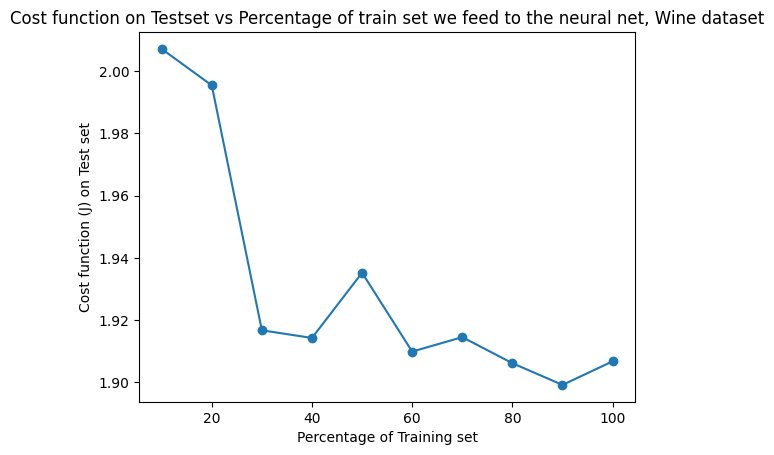

In [ ]:
# from neural_network import evaluationMetrics
import numpy as np
import matplotlib.pyplot as plt

num = []
for i in range(1, 11):
    num.append(10*i)

# houseVotesCostFunctions = []

# print('\n------------------------House Votes Dataset---------------------------\n')
# for i in range(1, 11):
#     print('----------------------Training with {percent}% of data-------------------'.format(percent=i*10))
#     evaluationMetricsForAllFolds, costFunctionsForEachFold, costFunctionsForEachTestFold = evaluationMetrics(
#         'datasets/hw3_house_votes_84.csv',
#         np.array([48, 24, 24, 2]), 1,
#         0.25, costOfTestSet=True, trainingSetPercentage=10*i)
#     print('Percentage: ', 10*i)
#     print('Evaluation metrics [Accuracy, Precision, Recall, F1 Score]: ',
#           np.average(evaluationMetricsForAllFolds, axis=0))
#     print('Cost function on test data for each fold run: ', costFunctionsForEachTestFold)
#     houseVotesCostFunctions.append(np.average(costFunctionsForEachTestFold))


# print('\nCost Function values by varying the trainset from 10% to 100%:')
# print('Train set percentages: ', num)
# print('Corresponding cost functions: ', houseVotesCostFunctions)
# print('\n')

# plt.title('Cost function on Testset vs Percentage of train set we feed to the neural net, House Votes dataset')
# plt.xlabel('Percentage of Training set')
# plt.ylabel('Cost function (J) on Test set')
# plt.plot(num, houseVotesCostFunctions, marker='o')
# plt.show()

wineCostFunctions = []

print('\n------------------------Wine Dataset---------------------------\n')
for i in range(1, 11):
    print('----------------------Training with {percent}% of data-------------------'.format(percent=i*10))
    evaluationMetricsForAllFolds, costFunctionsForEachFold, costFunctionsForEachTestFold = evaluationMetrics('hw3_wine.csv',np.array([13, 8, 4, 3]), 1,0.25, costOfTestSet=True, trainingSetPercentage=10*i)
    print('Percentage: ', 10*i)
    print('Evaluation metrics [Accuracy, Precision, Recall, F1 Score]: ',
          np.average(evaluationMetricsForAllFolds, axis=0))
    print('Cost function on test data for each fold run: ', costFunctionsForEachTestFold)
    wineCostFunctions.append(np.average(costFunctionsForEachTestFold))


print('\nCost Function values by varying the trainset from 10% to 100%:')
print('Train set percentages: ', num)
print('Corresponding cost functions: ', wineCostFunctions)
print('\n')

plt.title('Cost function on Testset vs Percentage of train set we feed to the neural net, Wine dataset')
plt.xlabel('Percentage of Training set')
plt.ylabel('Cost function (J) on Test set')
plt.plot(num, wineCostFunctions, marker='o')
plt.show()

# cancerCostFunctions = []

# print('\n------------------------Cancer Dataset---------------------------\n')
# for i in range(1, 11):
#     print('----------------------Training with {percent}% of data-------------------'.format(percent=i*10))
#     evaluationMetricsForAllFolds, costFunctionsForEachFold, costFunctionsForEachTestFold = evaluationMetrics(
#         'datasets/hw3_cancer.csv',
#         np.array([9, 8, 2]), 1,
#         0.25, costOfTestSet=True, trainingSetPercentage=10*i)
#     print('Percentage: ', 10*i)
#     print('Evaluation metrics [Accuracy, Precision, Recall, F1 Score]: ',
#           np.average(evaluationMetricsForAllFolds, axis=0))
#     print('Cost function on test data for each fold run: ', costFunctionsForEachTestFold)
#     cancerCostFunctions.append(np.average(costFunctionsForEachTestFold))


# print('\nCost Function values by varying the trainset from 10% to 100%:')
# print('Train set percentages: ', num)
# print('Corresponding cost functions: ', cancerCostFunctions)
# print('\n')

# plt.title('Cost function on Testset vs Percentage of train set we feed to the neural net, Cancer dataset')
# plt.xlabel('Percentage of Training set')
# plt.ylabel('Cost function (J) on Test set')
# plt.plot(num, cancerCostFunctions, marker='o')
# plt.show()

# cmcCostFunctions = []

# print('\n------------------------CMC Dataset---------------------------\n')
# for i in range(1, 11):
#     print('----------------------Training with {percent}% of data-------------------'.format(percent=i*10))
#     evaluationMetricsForAllFolds, costFunctionsForEachFold, costFunctionsForEachTestFold = evaluationMetrics(
#         'datasets/cmc.csv',
#         np.array([24, 18, 16, 3]), 1,
#         0.25, costOfTestSet=True, trainingSetPercentage=10*i)
#     print('Percentage: ', 10*i)
#     print('Evaluation metrics [Accuracy, Precision, Recall, F1 Score]: ',
#           np.average(evaluationMetricsForAllFolds, axis=0))
#     print('Cost function on test data for each fold run: ', costFunctionsForEachTestFold)
#     cmcCostFunctions.append(np.average(costFunctionsForEachTestFold))


# print('\nCost Function values by varying the trainset from 10% to 100%:')
# print('Train set percentages: ', num)
# print('Corresponding cost functions: ', cmcCostFunctions)
# print('\n')

# plt.title('Cost function on Testset vs Percentage of train set we feed to the neural net, CMC dataset')
# plt.xlabel('Percentage of Training set')
# plt.ylabel('Cost function (J) on Test set')
# plt.plot(num, cmcCostFunctions, marker='o')
# plt.show()


In [ ]:
thetas = {}
thetas[0] = np.array([[0.4, 0.1], [0.3, 0.2]])
thetas[1] = np.array([[0.7, 0.5, 0.6]])
alpha = 0
regLambda = 0
a = NeuralNetwork(np.array([1, 2, 1]), thetas, alpha, regLambda, isNumeric=True, logs=True)
a.costFunction(np.array([[0.13, 0.9], [0.42, 0.23]]))
a.train(np.array([[0.13, 0.9], [0.42, 0.23]]))

a1 : [1.   0.13]
z2 : [0.413 0.326]
a2 : [1.        0.601807  0.5807858]
z3 : [1.34937498]
a3 : [0.79402743]
f(x): [0.79402743]
Predicted output for instance 1: [0.79402743]
Expected output for instance 1: [0.9]
Cost, J, associated with instance 1: 0.36557477431084995
-----------------------------------------------------
a1 : [1.   0.42]
z2 : [0.442 0.384]
a2 : [1.         0.60873549 0.59483749]
z3 : [1.36127024]
a3 : [0.79596607]
f(x): [0.79596607]
Predicted output for instance 2: [0.79596607]
Expected output for instance 2: [0.23]
Cost, J, associated with instance 2: 1.2763768066887786
-----------------------------------------------------
Final (regularized) cost, j, based on the complete training set: 0.8209757904998143
-------------------------------------------------------
Running back propogation
Computing gradients based on training instance 1:

delta3: [-0.10597257]
delta2: [-0.01269739 -0.01548092]


Gradients of Theta2 based on training instance 1: 
[[-0.10597257 -0.06377504 

0